In [29]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from tqdm import tqdm
from scipy.stats import ksone, kstwobign
import pandas as pd
%matplotlib inline

In [2]:
from setup_files.mocks.mock_models import results as mock_res, models as mock_models, run_names as mock_names

In [3]:
%%time
from results import models, results, pcmds, data, radii_am, radii_kpc, dmods, regions
import results as rr

CPU times: user 16.4 ms, sys: 4.58 ms, total: 21 ms
Wall time: 32.1 ms


In [4]:
%%time
for i in [14]:
    print(i)
    rr.load_model(i, all_quads=False)
# rr.load_model(9, all_quads=False)

14
M87
Skipping M87_a1_m14
Skipping M87_b1_m14
Skipping M87_c1_m14
M87v2
Skipping M87v2_a1_m14
Skipping M87v2_b1_m14
Skipping M87v2_c1_m14
M49
Skipping M49_a1_m14
Skipping M49_b1_m14
Skipping M49_c1_m14
NGC3377
NGC4993
Skipping NGC4993_a1_m14
Skipping NGC4993_b1_m14
Skipping NGC4993_c1_m14
M31 Bulge
Skipping M31_e_m14
Skipping M31_d_m14
Skipping M31_c_m14
Skipping M31_b_m14
Skipping M31_a_m14
CPU times: user 4.35 s, sys: 95.9 ms, total: 4.45 s
Wall time: 4.58 s


In [5]:
results.update(mock_res)
ks = list(results.keys())
for k in ks:
    if ('mock' not in k) and ('NGC3377' not in k):
        results.pop(k)

In [6]:
def plot_tau_cumulative(tau, ax=None, iso_step=0.01, lower=7.0, upper=10.1, xtext=7.5, text_kwargs={}, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(8,5))
    m = ppy.sfhmodels.TauModel(np.array([0., tau]), iso_step=-1)
    m.iso_edges = np.arange(0., 10.2, iso_step)
    ages, sfhs = m.get_vals()
    idx = (ages >= lower)&(ages<=upper)
    x = ages[idx]
    y = np.cumsum(sfhs)[idx]
    y /= y.max()
    ax.plot(x, y, **kwargs)
    kws = {'verticalalignment': 'bottom',
          'horizontalalignment':'left',
          'fontsize': 14, 
          'rotation': 14.}
    kws.update(text_kwargs)
    ytext = y[np.argmin(np.abs(x-xtext))] * 1.05
    ax.text(xtext, ytext, r'$\tau$ = '+f'{tau:.0f} Gyr', **kws)
    return ax

In [7]:
def residuals(k, ax=None, force_resim=False, median=False, residuals=True, residual_kwargs={}, model_kwargs={}, data_kwargs={},
              bins=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
    g = k.split('_')[0]
    if force_resim:
        if k in pcmds:
            pcmds.pop(k)
    if k not in pcmds:
        print(f'Modeling best fit for {k}')
        m = (results[k].median_model if median else results[k].best_model)
        is_ssp = isinstance(m.sfh_model, ppy.sfhmodels.SSPModel)
        if isinstance(m.distance_model, ppy.distancemodels.FixedDistance):
            m.distance_model.dmod = dmods[g]
        pcmds[k], _ = drivers[g].simulate(m, (256 if is_ssp else 128), sky_noise=sky[g], dither=False,
                                          mag_system=('ab' if g=='M31' else 'vega'), dark_per_sec=0.0127)
    pcmd_all = np.append(pcmds[k], data[k], axis=1)
    bins = bins or [np.arange(min(pcmd_all[0])-0.1, max(pcmd_all[0])+0.1, 0.05), np.arange(min(pcmd_all[1])-0.1, max(pcmd_all[1])+0.1, 0.05)]
    if residuals:
        ppy.plotting.plot_pcmd_contours(data[k], color='k', alpha=1.0, ls='-', lw=2, label='Data', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **data_kwargs)
        ppy.plotting.plot_pcmd_contours(pcmds[k], color=colors[1], alpha=1.0, ls='-', lw=1, label='Model', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **model_kwargs)
        a, ll, bins, norm, = ppy.plotting.plot_pcmd_residual(pcmds[k], data[k], ax=ax, bins=bins, **residual_kwargs)
    else:
        ppy.plotting.plot_pcmd_contours(data[k], alpha=1.0, ls='-', lw=2, label='Data', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **data_kwargs)
        ppy.plotting.plot_pcmd_contours(pcmds[k], color=model_kwargs.pop('color', colors[1]), alpha=1.0, ls='-', lw=1, label='Model', ax=ax, span=[[bins[1][0], bins[1][-1]],[bins[0][0], bins[0][-1]]], **model_kwargs)
        norm = None
    ppy.plotting.plot_isochrone(iso_models[g], axes=ax, alpha=0.)
    return ax, norm

In [8]:
results

{'NGC3377_a1_m14': <pcmdpy.results.results.ResultsPlotter at 0x1345b3828>,
 'NGC3377_b1_m14': <pcmdpy.results.results.ResultsPlotter at 0x1388544a8>,
 'NGC3377_c1_m14': <pcmdpy.results.results.ResultsPlotter at 0x138896c18>,
 'mock_1': <pcmdpy.results.results.ResultsPlotter at 0x12de27400>,
 'mock_10': <pcmdpy.results.results.ResultsPlotter at 0x12debbe48>,
 'mock_11': <pcmdpy.results.results.ResultsPlotter at 0x12deb7fd0>,
 'mock_12': <pcmdpy.results.results.ResultsPlotter at 0x12debb9e8>,
 'mock_2': <pcmdpy.results.results.ResultsPlotter at 0x10cba5c50>,
 'mock_3': <pcmdpy.results.results.ResultsPlotter at 0x1156d3e80>,
 'mock_4': <pcmdpy.results.results.ResultsPlotter at 0x12de94dd8>,
 'mock_5': <pcmdpy.results.results.ResultsPlotter at 0x12debbe10>,
 'mock_6': <pcmdpy.results.results.ResultsPlotter at 0x12debbc18>,
 'mock_7': <pcmdpy.results.results.ResultsPlotter at 0x12debb7f0>,
 'mock_8': <pcmdpy.results.results.ResultsPlotter at 0x13459ce10>,
 'mock_9': <pcmdpy.results.results.

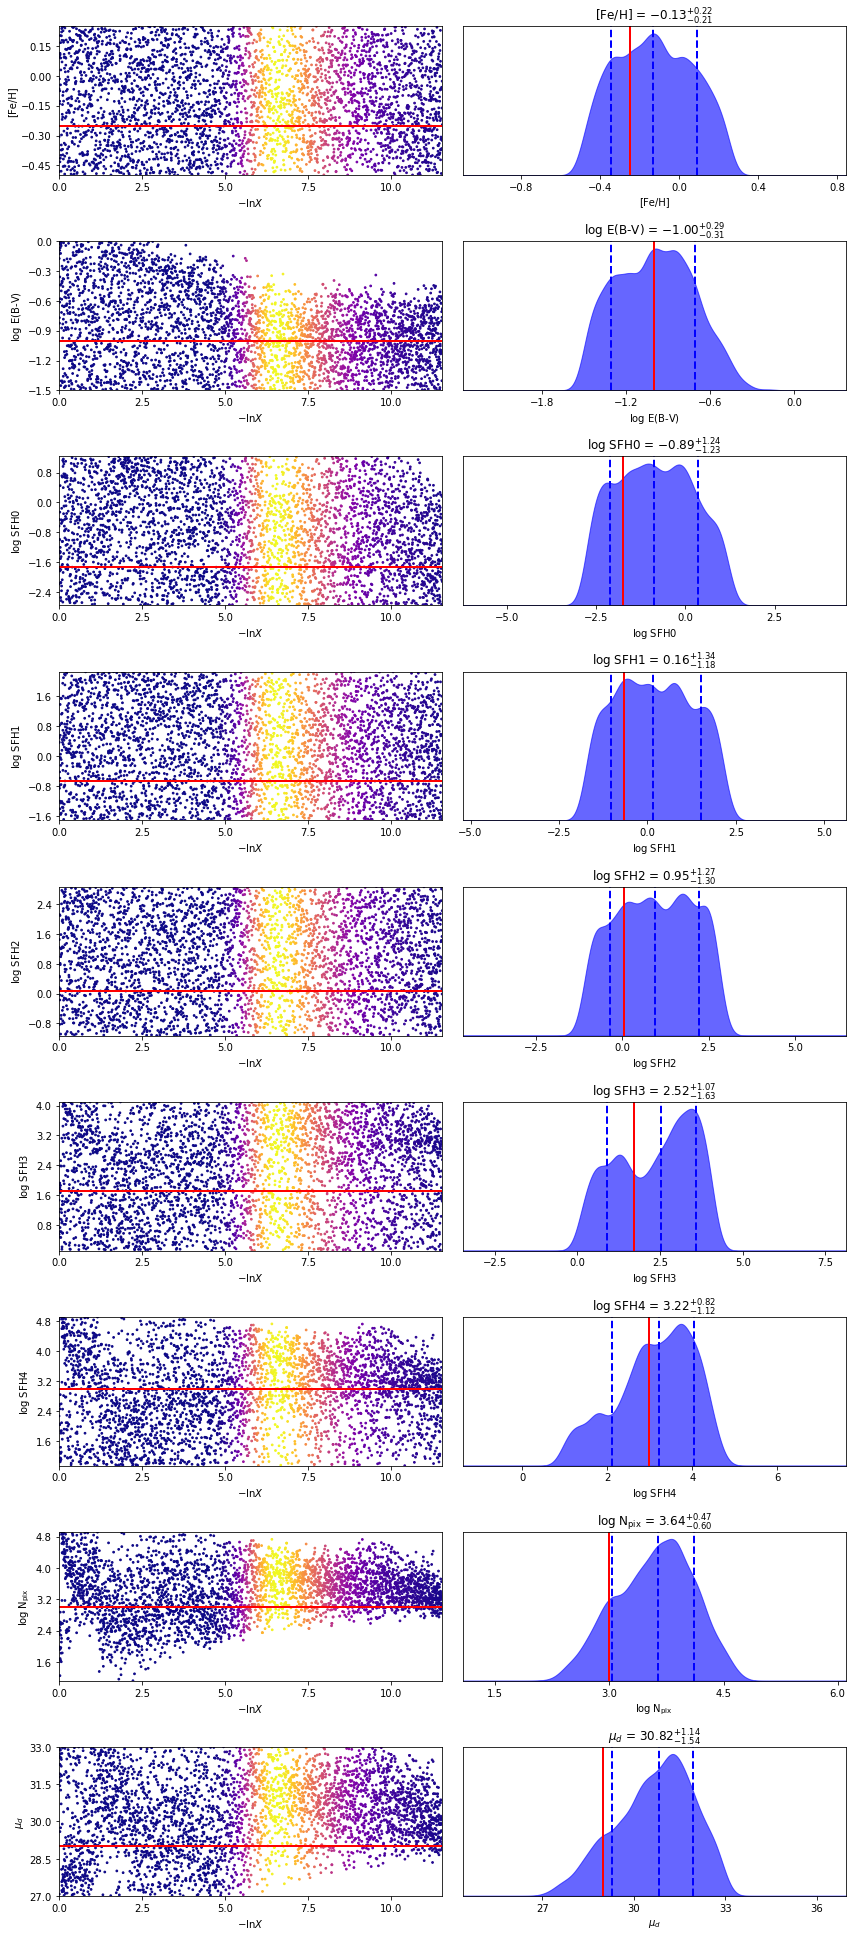

In [9]:
results['mock_3'].plot_trace();

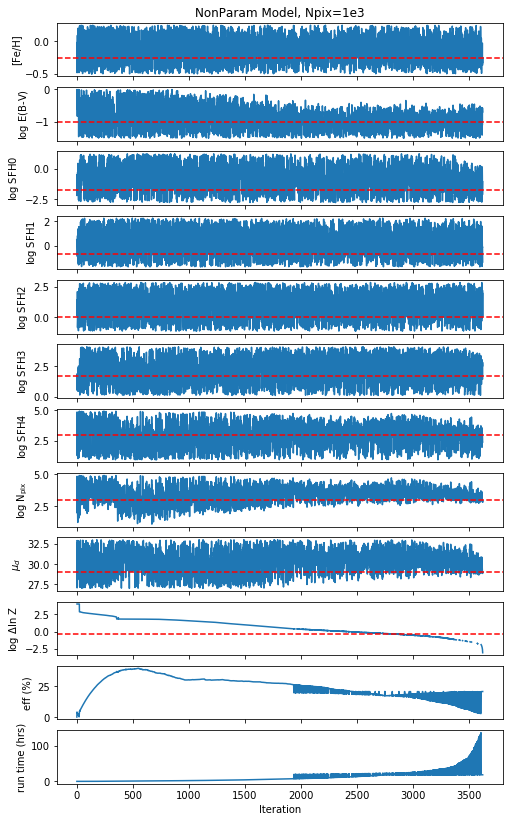

In [10]:
results['mock_3'].plot_chains();

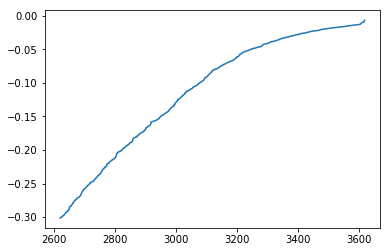

In [11]:
plt.plot(results['mock_3'].df.logl.tail(1000))

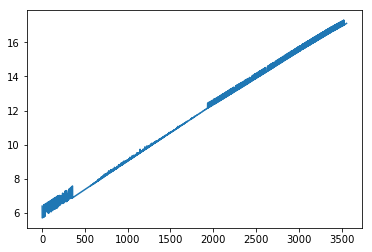

In [13]:
plt.plot(results['mock_3'].df.logl - results['mock_3'].df.logwt)

In [75]:
r = results['mock_1'].copy()

In [76]:
r.df.logl *= 100.

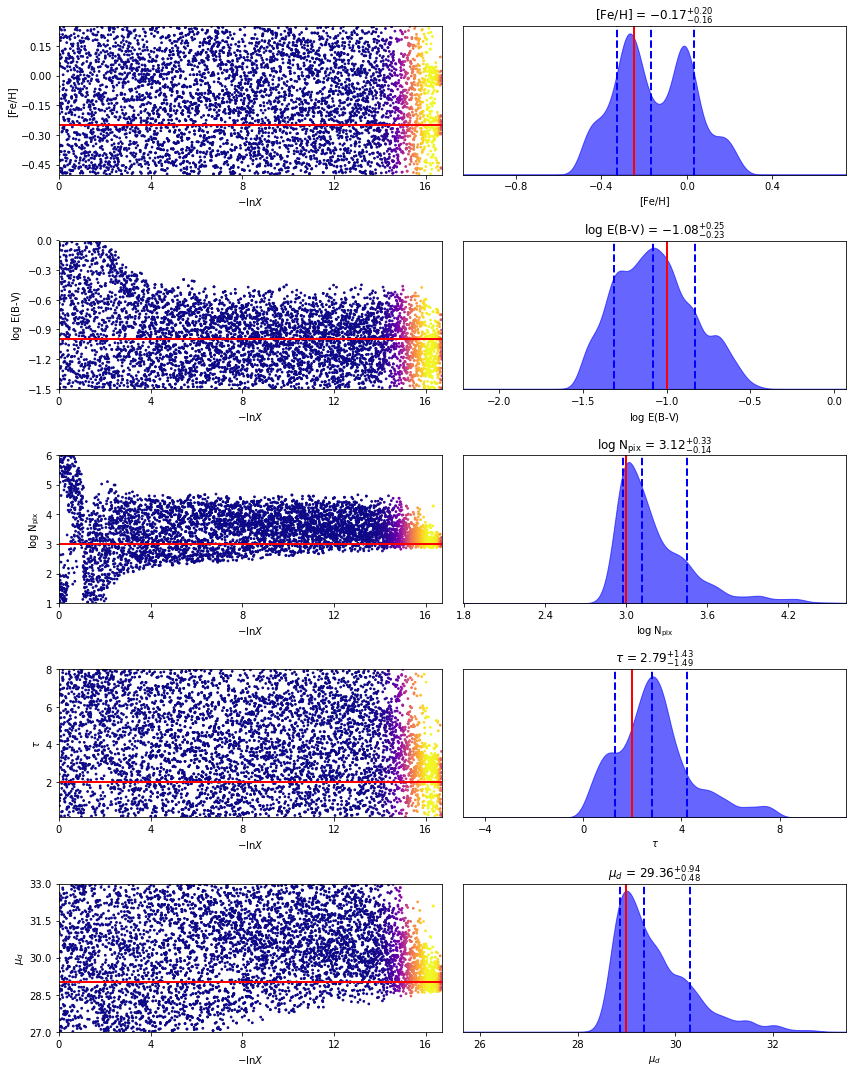

In [77]:
r.plot_trace(max_logl=10000.);

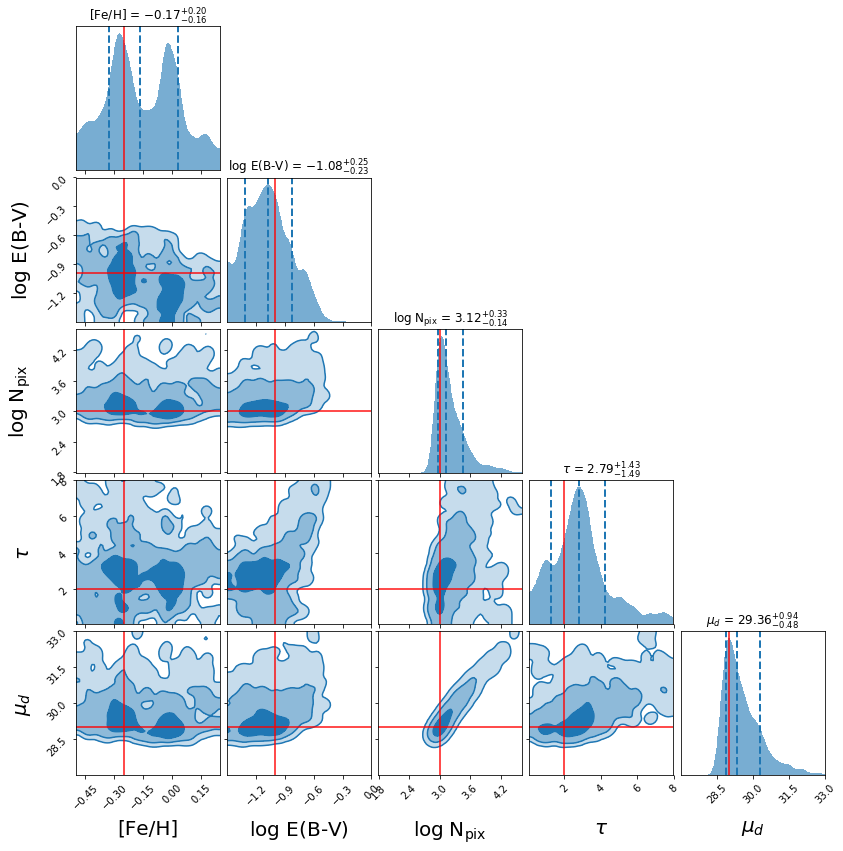

In [78]:
r.plot_corner(max_logl=1000.);